<a href="https://colab.research.google.com/github/alexandraizhevskaya/study_projects/blob/master/Churn_prediction_DL_school%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Автор: Alexandra Izhevskaya

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/t/f50bc21dbe0e42dabe5e32a21f2e5235) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика. 

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование.

In [ ]:
! pip install catboost
! pip install shap

In [ ]:
# analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# modeling
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
import catboost
from catboost import CatBoostClassifier


# metrics
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score, )
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

Загружаем данные и смотрим на случайные 10 строк

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Копия train.csv')
test = pd.read_csv('/content/drive/My Drive/Копия test.csv')

In [ ]:
data.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2081,41,94.55,3851.45,Male,1,Yes,No,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
4013,71,108.55,7616,Male,0,Yes,No,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0
2355,24,101.05,2391.8,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
1603,67,24.85,1583.5,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
4907,33,20.10,579.4,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
2137,52,105.05,5624.85,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
226,16,98.75,1587.55,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
1924,72,93.05,6735.05,Male,1,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4961,13,20.40,251.65,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,0
1367,26,73.50,1905.7,Female,0,Yes,No,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),0


In [ ]:
test.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
1417,54,20.35,1092.35,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic)
974,67,24.65,1620.45,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)
173,11,58.95,601.6,Female,0,No,No,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Mailed check
319,17,88.25,1460.65,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,No,Electronic check
686,10,20.35,176.3,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1201,46,21.10,937.1,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Electronic check
808,53,94.25,4867.95,Male,0,Yes,No,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,One year,Yes,Bank transfer (automatic)
78,57,107.95,5969.85,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Electronic check
569,51,78.65,3950.85,Female,0,Yes,No,Yes,Yes,DSL,No,Yes,No,Yes,Yes,Yes,One year,Yes,Credit card (automatic)
1041,46,94.65,4312.5,Male,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,One year,Yes,Electronic check


In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Итак, можно увидеть, что объектов типа NaN в выборке не наблюдается, однако это еще не все. В колонке с TotalSpent были обнаружены пустые строки, так что надо что-то с этим делать:

In [ ]:
list(data.TotalSpent.value_counts().index.unique())[0]

' '

 На всякий случай выполняем проверку остальных колонок

In [ ]:
for column in feature_cols:
  if ' ' in list(data[column].value_counts().index.unique()):
    print('{} contains empty strings'.format(column))

TotalSpent contains empty strings


Делаем вывод, что такое наблюдается только в TotalSpent. Еще проверяем на дупликаты, а то мало ли

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

## Пункт 1 
Графики

Тут временнно заменяем пропущенные значения в TotalSpent на медианные, чтобы построить графики (в результате такая замена и показала себя как самая подходящая)

In [ ]:
TotalSpent = data.TotalSpent
data.TotalSpent = pd.to_numeric(data.TotalSpent,errors='coerce')
test.TotalSpent = pd.to_numeric(test.TotalSpent,errors='coerce')
data.TotalSpent = data.TotalSpent.replace(" ",np.nan)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
data.TotalSpent = imp_mean.fit_transform(data.TotalSpent.values.reshape(len(data), 1))
test.TotalSpent = imp_mean.transform(test.TotalSpent.values.reshape(len(test), 1))

Хотя вообще, стоит заметить, что этот показатель отсутствует у новых пользователей, так как они еще неуспели ничего потратить. Логичным в таком случае кажется заменить пропуски на 0. Но на практике качество с 0 вышло хуже

In [ ]:
data[data.TotalSpent.isnull()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [ ]:
# data.loc[data.TotalSpent.isnull(), 'TotalSpent'] = 0
# test.loc[test.TotalSpent.isnull(), 'TotalSpent'] = 0

Прежде всего не помешает взглянуть на корреляцию: самая сильная и при этом положительная корреляция наблюдается между TotalSpent/ClientPeriod  и TotalSpent/MonthlySpending, что очень закономерно. Наибольшая негативная корреляция наблюдается между целевой переменной и ClientPeriod (что тоже неудивительно).

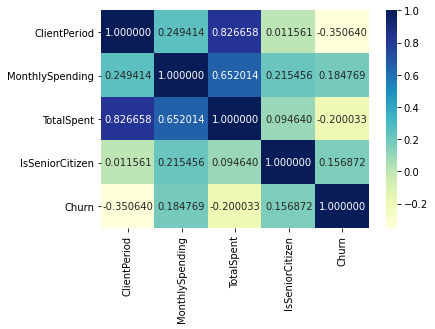

In [ ]:
 sns.heatmap(data.corr(), annot=True, fmt="f", cmap="YlGnBu")

Далее строим графики распределения численных признаков:

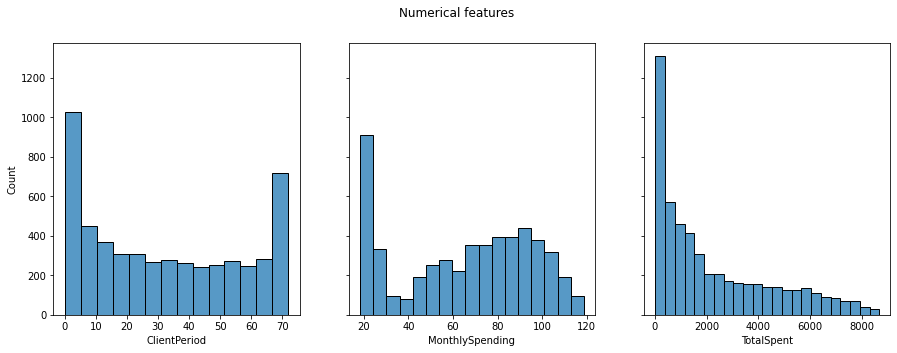

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Numerical features ')
for i, j in enumerate(num_cols):
  sns.histplot(ax=axes[i], data=data, x=j)
  

Распределения явно далеки от нормальных, есть отдельные высокие значения, сильно контрастирующие с основной массой распределения. В TotalSpent наблюдается сильно скошенное вправо распределение. Ту же картину отражают и ящики с усами:

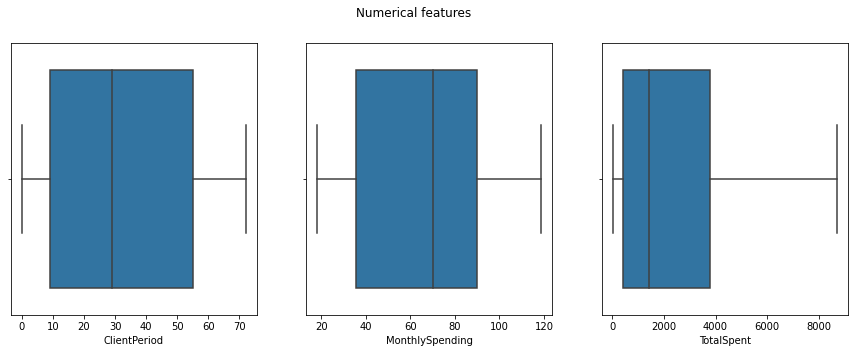

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Numerical features ')
for i, j in enumerate(num_cols):
  sns.boxplot(ax=axes[i], data=data, x=j)

Теперь построим барплоты для категориальных признаков. Их делим на 2 части, так как очень много...Все равно выходит достаточно мелко, но графики легко приближаются и можно рассмотреть все подписи

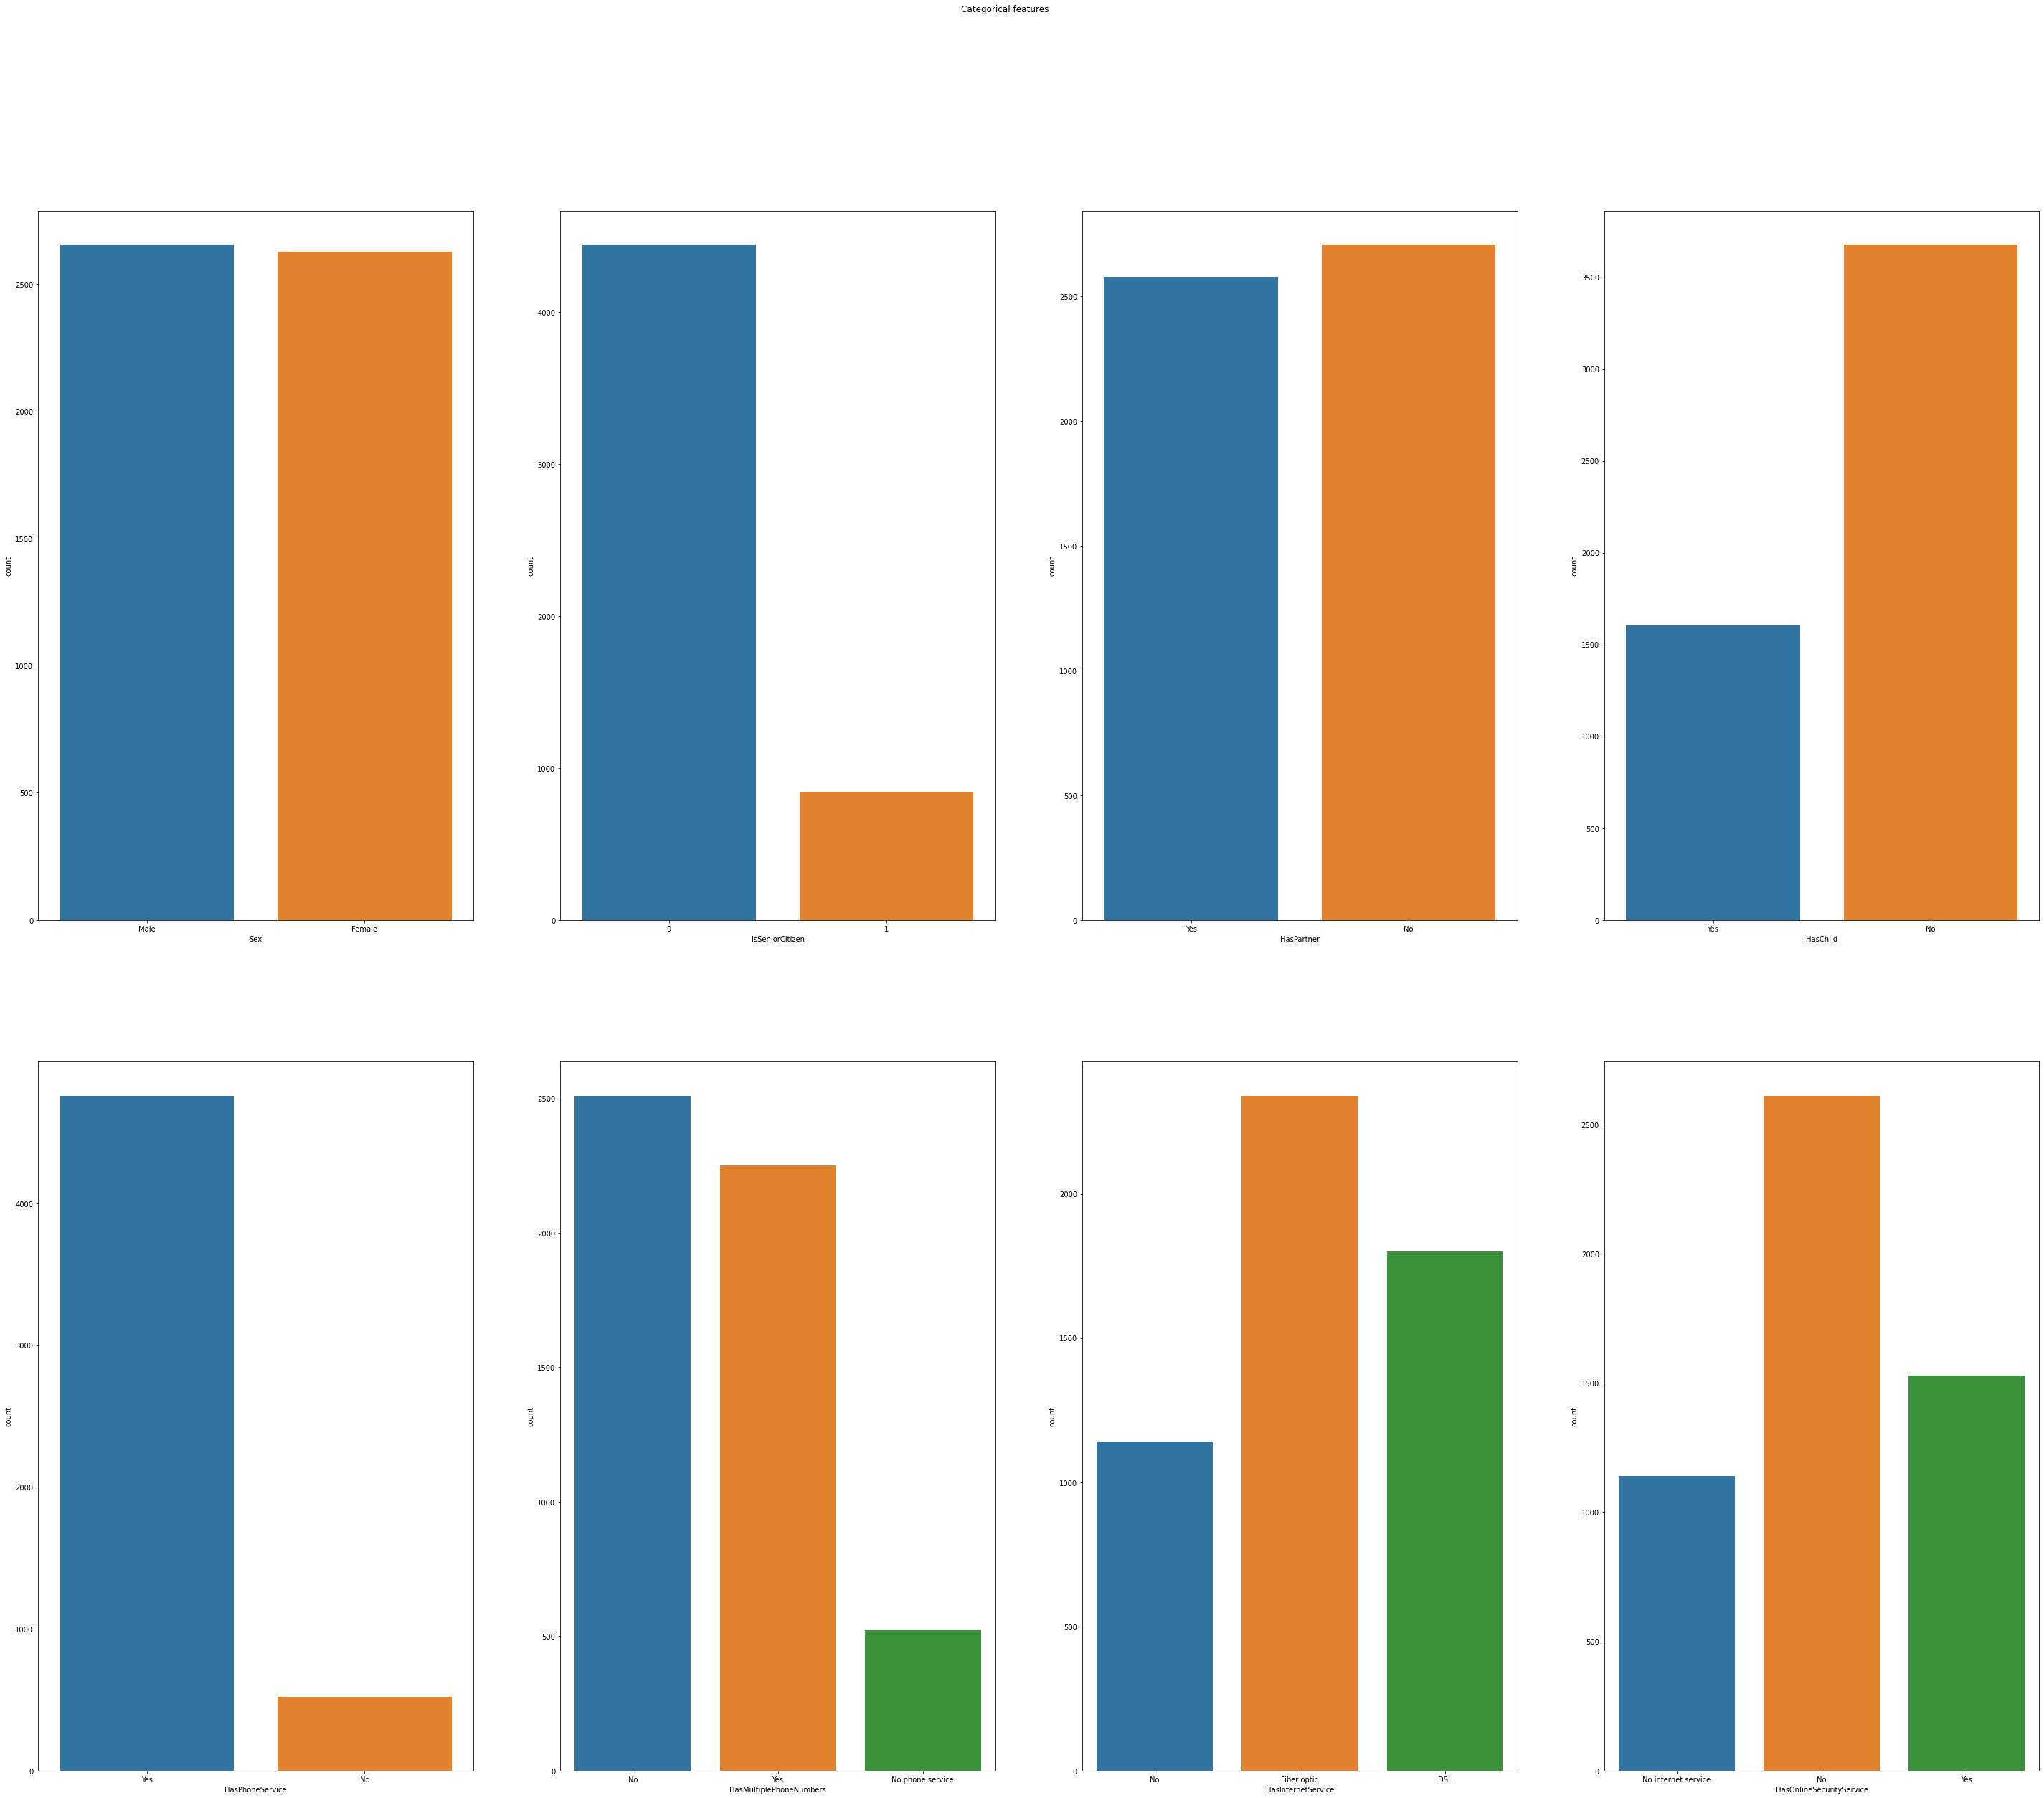

In [ ]:
indices = []
for i in range(2):
  for j in range(4):
    indices.append((i,j))

fig, axes = plt.subplots(2, 4, figsize=(50, 40))
axis = []
fig.suptitle('Categorical features ')
for i, j in enumerate(cat_cols[:8]):
  sns.countplot(ax=axes[indices[i][0], indices[i][1]], x=j, data=data)

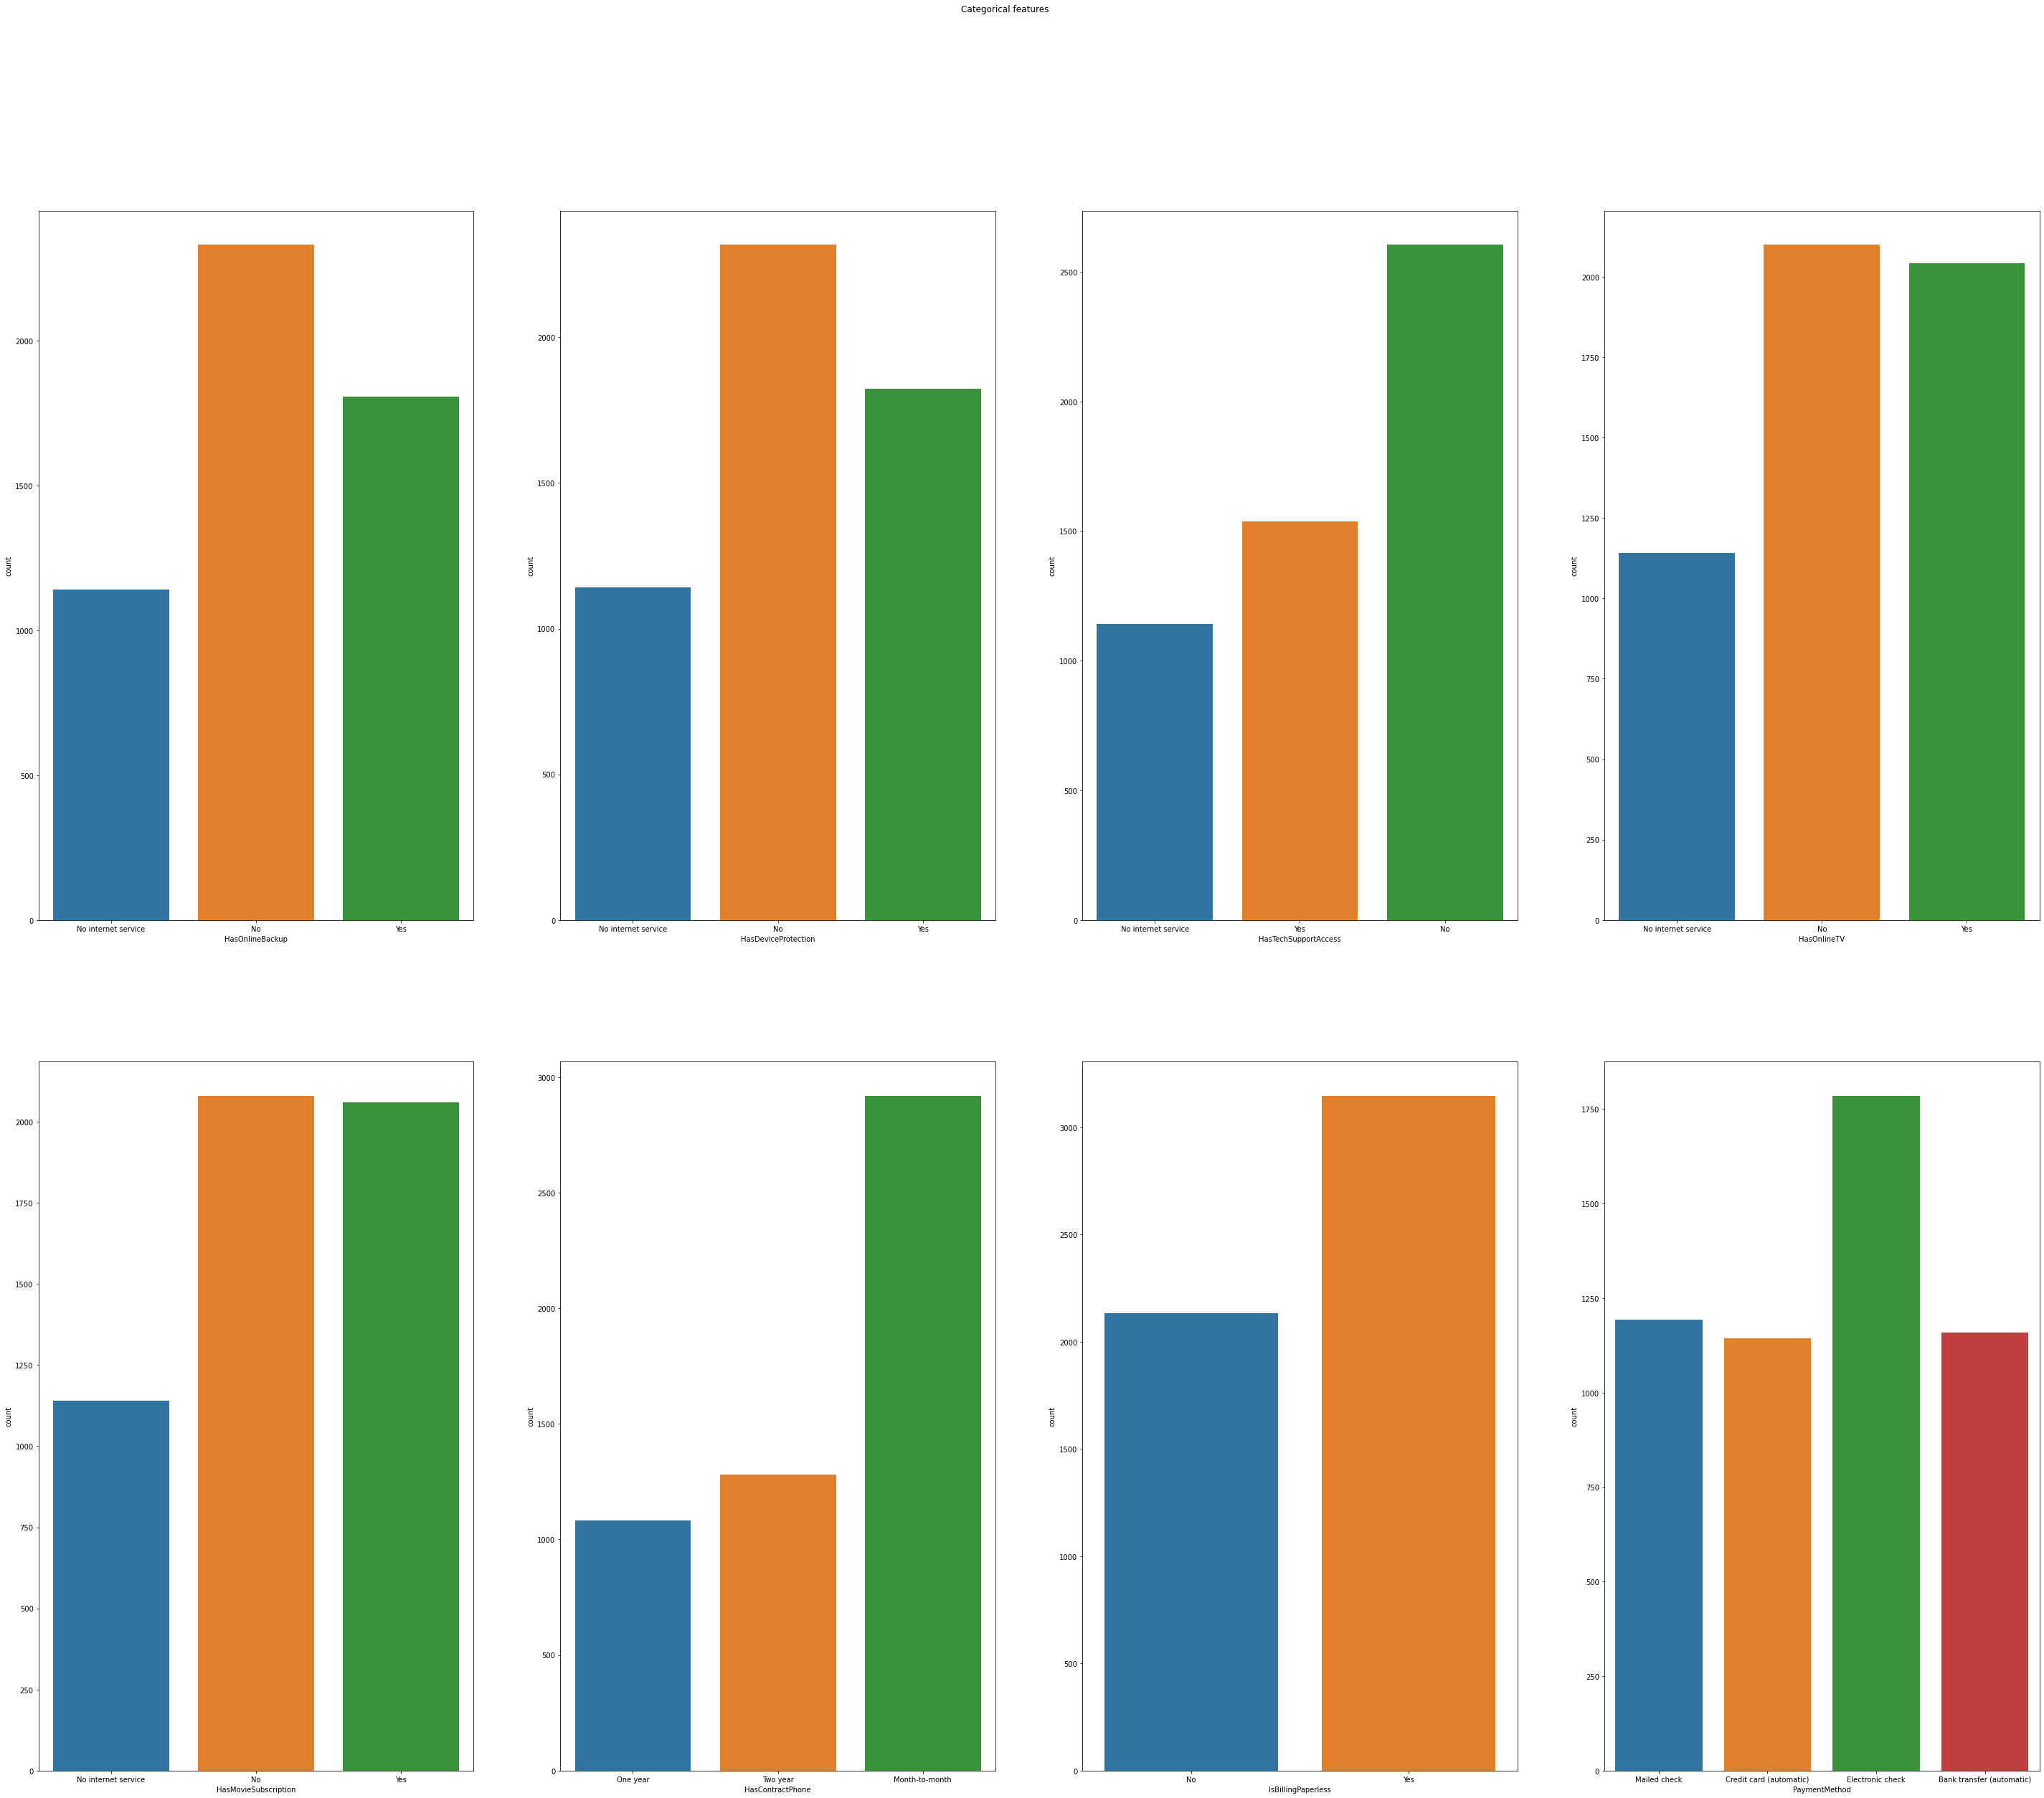

In [ ]:
indices = []
for i in range(2):
  for j in range(4):
    indices.append((i,j))

fig, axes = plt.subplots(2, 4, figsize=(50, 40))
axis = []
fig.suptitle('Categorical features ')
for i, j in enumerate(cat_cols[8:]):
  sns.countplot(ax=axes[indices[i][0], indices[i][1]], x=j, data=data)

#### По данным признакам можно составить примерный профиль большинства пользователей
Видим, что мужчин и женщин поровну, также, как с партнером и без, пенсионеров в принципе достаточно мало, как и людей с детьми. Подавляющее большинство пользуется телефоном, притом у значительной части номеров больше одного. У большей части пользователей нет интернет защиты и защиты устройства и доступа к техподдержке. Интересно, что примерно с равной вероятностью у пользователей есть и нет онлайн тв и подписка на фильмы. Большинство платит ежемесячно безналичным рассчетом, также большинство предпочитает электронные платежи, хотя и у других видов много поклонников.

Также строим еще один график (но большой)

<Figure size 1440x720 with 0 Axes>

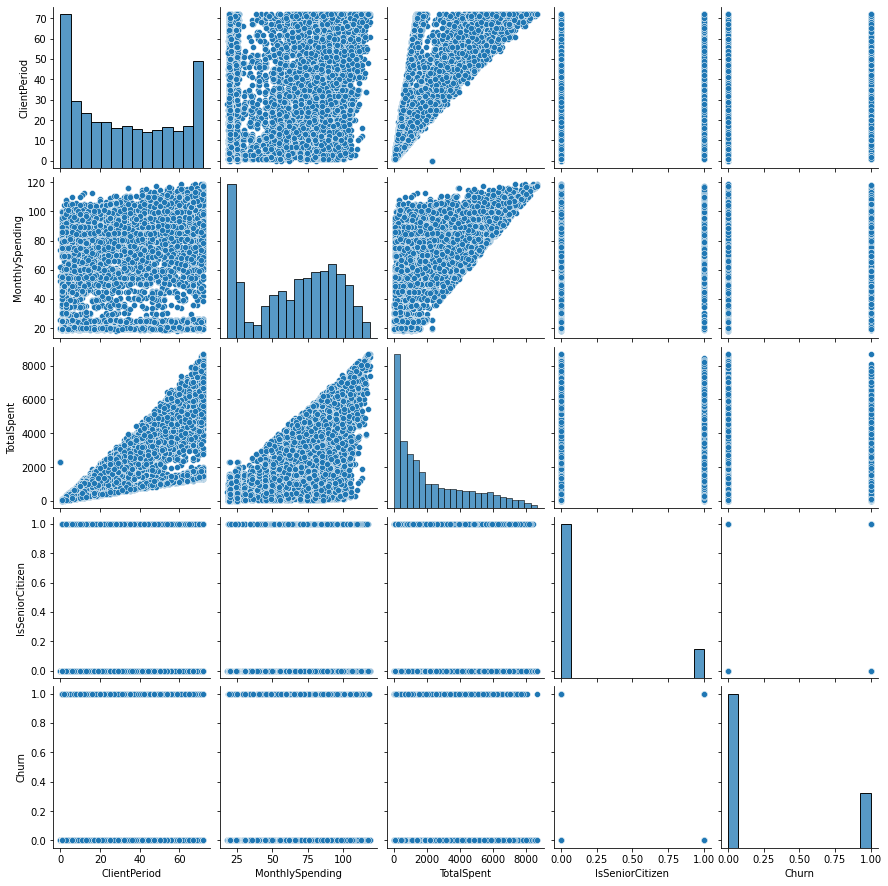

In [ ]:
numeric = data.select_dtypes(include=['float', 'int'])
plt.figure(figsize=(20, 10))
sns.pairplot(numeric, )

В TotalSpent наблюдается аномалия! Видимо, кстати из-за замены на медианное значение...

## Пункт 2
распределение целевой переменной

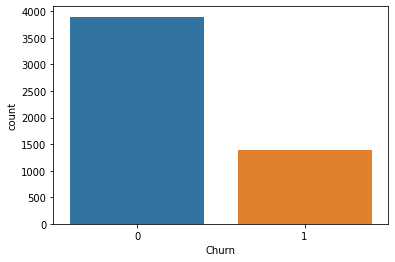

In [ ]:
sns.countplot(x='Churn', data=data)

Очевидно, что мы имеем дело с несбалансированными классами. Объектов с меткой 1 примерно в 2,5 раза меньше, чем 0. Ситуация такая себе

## Пункт 3
Все остальное\
Сначала таблички, которые могли бы оказаться полезными (возможно)

In [ ]:
data.groupby('Churn').mean()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen
Churn,,,,
0,37.525911,61.602719,2563.205006,0.125192
1,17.951590,74.281178,1525.831864,0.255780


Интересно, ушедшие пользователи в среднем потратили больше, но при этом в месяц больше платят тех кто остался

In [ ]:
data.groupby('PaymentMethod').mean()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
PaymentMethod,,,,,
Bank transfer (automatic),42.993097,67.209448,3052.438983,0.151855,0.168248
Credit card (automatic),43.206474,67.157087,3097.425101,0.139983,0.144357
Electronic check,25.318589,75.883231,2091.254927,0.246361,0.444569
Mailed check,22.351759,44.178224,1080.409919,0.055276,0.192630


Те, кто платят электронно, тратят больше всего, и черн у них значительно побольше, чем у клиентов, юзающих другие виды платежа

In [ ]:
data.groupby('Sex').mean()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
Sex,,,,,
Female,32.239817,65.282033,2277.385193,0.154549,0.265702
Male,32.552542,64.571243,2305.248027,0.164218,0.258380


А вот от пола отток, кажется,не особо зависит

In [ ]:
data.groupby('HasContractPhone').mean()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
HasContractPhone,,,,,
Month-to-month,18.147603,66.523014,1380.004469,0.206507,0.421575
One year,41.929760,65.038771,3024.421479,0.121996,0.110906
Two year,56.845312,61.182344,3750.849472,0.083594,0.025781


In [ ]:
data.groupby('IsBillingPaperless').mean()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
IsBillingPaperless,,,,,
No,32.137301,52.286129,1861.273427,0.091846,0.158388
Yes,32.573062,73.492360,2582.962809,0.205210,0.332274


Те, кто платят без бумажек, также отваливаются в большей степени

Теперь будет еще немного графиков просто для наглядности

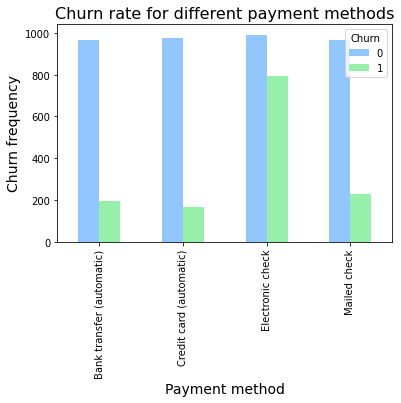

In [ ]:
pd.crosstab(data['PaymentMethod'], data['Churn']).plot(kind='bar')
plt.title('Churn rate for different payment methods', fontsize=16)
plt.xlabel('Payment method', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

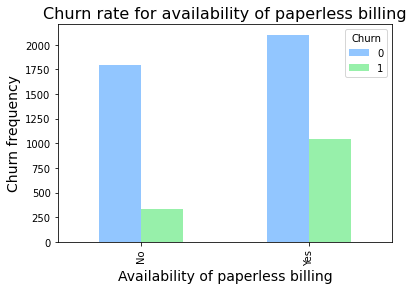

In [ ]:
pd.crosstab(data['IsBillingPaperless'], data['Churn']).plot(kind='bar')
plt.title('Churn rate for availability of paperless billing', fontsize=16)
plt.xlabel('Availability of paperless billing', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

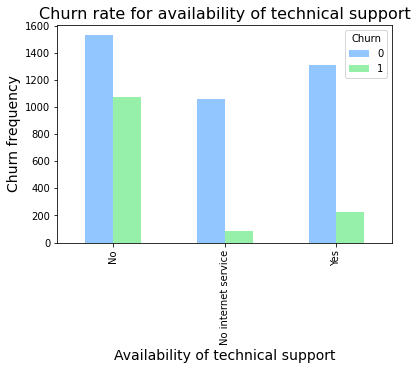

In [ ]:
pd.crosstab(data['HasTechSupportAccess'], data['Churn']).plot(kind='bar')
plt.title('Churn rate for availability of technical support', fontsize=16)
plt.xlabel('Availability of technical support', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

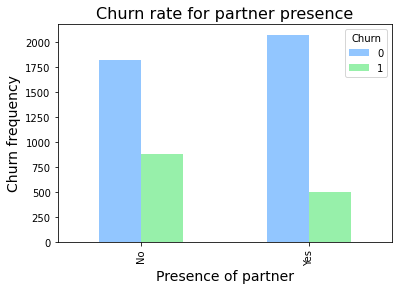

In [ ]:
pd.crosstab(data['HasPartner'], data['Churn']).plot(kind='bar')
plt.title('Churn rate for partner presence', fontsize=16)
plt.xlabel('Presence of partner', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

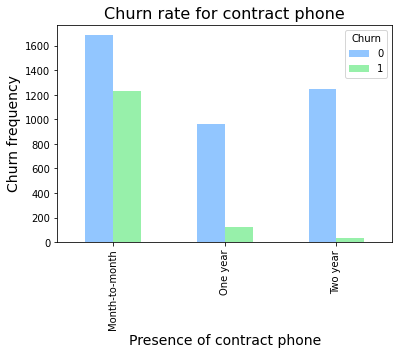

In [ ]:
pd.crosstab(data['HasContractPhone'], data['Churn']).plot(kind='bar')
plt.title('Churn rate for contract phone', fontsize=16)
plt.xlabel('Presence of contract phone', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

 Вообще есть ощущение, что клиенты часто ливают именно из-за каких-то технических проблем: электронная оплата, отсутствие технической поддержки, и т. д.\
Ну и еще график напоследок

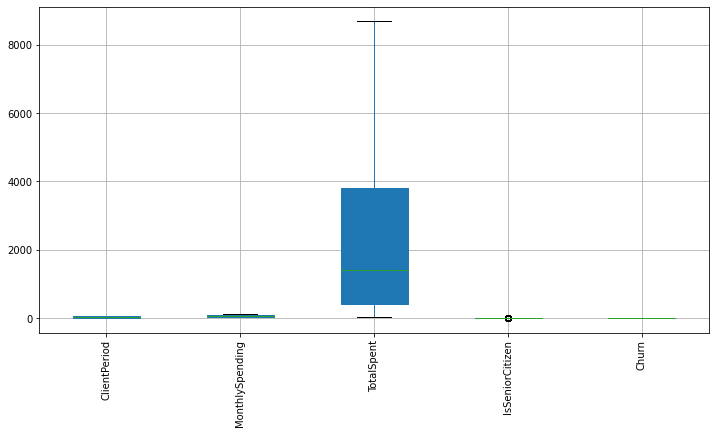

In [ ]:
# ну это я замахнулся на аутлайеров. Но что-то не особо
plt.figure(figsize=(12,6))
bplot = data.boxplot(patch_artist=True)
plt.xticks(rotation=90)       
plt.show()

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

## Пункт 1
Обработка данных для регрессии

In [ ]:
# делим на обучающую и валидационную выборку
y = data.Churn
data.drop(columns=['Churn'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

In [ ]:
# собираем небольшого трансформера (почти как БЕРТ, но не БЕРТ:())
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                        ('scaler', 'passthrough')])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])
data_transformer = ColumnTransformer(transformers=[
                                    ('numerical', numerical_transformer, num_cols),
                                    ('categorical', categorical_transformer, cat_cols)])

preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])
classifier = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(random_state=0, max_iter=10000))])

## Пункт 2 
Подбор параметров для логистической регрессии

In [ ]:
# подбираем параметры по сетке
param_grid = {
    'preprocessor__data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__data_transformer__categorical__imputer__strategy': ['constant','most_frequent'],
    'preprocessor__data_transformer__numerical__scaler': [StandardScaler(), RobustScaler(), \
                                                          MinMaxScaler()],
    'classifier__C': [0.1, 1.0, 10, 100],
    'classifier__solver': ['liblinear','newton-cg', 'lbfgs','sag','saga']
}
scorer = make_scorer(roc_auc_score)

In [ ]:
clf = GridSearchCV(classifier, 
                   param_grid=param_grid, 
                   scoring=scorer)

clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Pipeline(memory=None,
                                                 steps=[('data_transformer',
                                                         ColumnTransformer(n_jobs=None,
                                                                           remainder='drop',
                                                                           sparse_threshold=0.3,
                                                                           transformer_weights=None,
                                                                           transformers=[('numerical',
                                                                                          Pipeline(memory=None,
                                                                                                   steps=[('imputer',
         

Полученное качество:

In [ ]:
y_pred = clf.best_estimator_.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred))

0.8459796853357956


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

## Пункт 1
Запуск кэтбуст

Выкидываем лишние признаки, оторые кажутся не особо значимыми (вообще они откинуты на основе значений важности признаков самого Catboost после обучения первичной модели

In [ ]:
data.drop(columns=['HasPhoneService','HasChild','HasPartner', 'IsSeniorCitizen'], axis=1, inplace=True)
test.drop(columns=['HasPhoneService','HasChild','HasPartner', 'IsSeniorCitizen'], axis=1, inplace=True)

In [ ]:
# убираем лишнее
cat_cols = ['HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod',
 'Sex',
  'HasOnlineTV']

In [ ]:
# делим выборку, создаем пулы
X_train, X_val,  y_train, y_val = train_test_split(data, y, test_size=0.2, random_state=10007) #123 1005 #10007
train_pool = catboost.Pool(X_train, y_train, cat_features=cat_cols)
val_pool = catboost.Pool(X_val, y_val,  cat_features=cat_cols)
full_data_pool = catboost.Pool(data, y,  cat_features=cat_cols)

Разбиваем - обучаем

In [ ]:
# лучшая модель собственно (именно ее предсказание отправлено на кэггл)
model = CatBoostClassifier(eval_metric='AUC', use_best_model=True)
model.fit(train_pool, eval_set=(val_pool))
preds_class = model.predict(val_pool)
preds_proba = model.predict_proba(val_pool)
preds_raw = model.predict(val_pool, prediction_type='RawFormulaVal')
print(roc_auc_score(y_val, preds_proba[:,1]))

Learning rate set to 0.045236
0:	test: 0.8234524	best: 0.8234524 (0)	total: 14.7ms	remaining: 14.7s
1:	test: 0.8215422	best: 0.8234524 (0)	total: 28.1ms	remaining: 14s
2:	test: 0.8315769	best: 0.8315769 (2)	total: 42.2ms	remaining: 14s
3:	test: 0.8335339	best: 0.8335339 (3)	total: 54.4ms	remaining: 13.6s
4:	test: 0.8334113	best: 0.8335339 (3)	total: 67ms	remaining: 13.3s
5:	test: 0.8348401	best: 0.8348401 (5)	total: 77.5ms	remaining: 12.8s
6:	test: 0.8365876	best: 0.8365876 (6)	total: 91.4ms	remaining: 13s
7:	test: 0.8363134	best: 0.8365876 (6)	total: 102ms	remaining: 12.7s
8:	test: 0.8374502	best: 0.8374502 (8)	total: 117ms	remaining: 12.8s
9:	test: 0.8382548	best: 0.8382548 (9)	total: 124ms	remaining: 12.3s
10:	test: 0.8411279	best: 0.8411279 (10)	total: 136ms	remaining: 12.2s
11:	test: 0.8423561	best: 0.8423561 (11)	total: 142ms	remaining: 11.7s
12:	test: 0.8434705	best: 0.8434705 (12)	total: 155ms	remaining: 11.7s
13:	test: 0.8434705	best: 0.8434705 (12)	total: 167ms	remaining: 11.

In [ ]:
print(roc_auc_score(y_val, preds_proba[:,1]))

0.8513186401690427


## Пункт 2
Попытка улучшить модель подбором параметров

Во первых, оценим качество на фолдах, а не только на одном сэмпле

In [ ]:

from sklearn.model_selection import StratifiedKFold

n_fold = 4 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=10007)

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 10007, 
          'cat_features':cat_cols
         }

test_data = catboost.Pool(data=test,
                 cat_features=cat_cols)

scores = []
prediction = np.zeros(test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(data, y)):
    
    X_train, X_valid = data.iloc[train_index], data.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = catboost.Pool(data=X_train, 
                      label=y_train,
                      cat_features=cat_cols)
    valid_data = catboost.Pool(data=X_valid, 
                      label=y_valid,
                      cat_features=cat_cols)
    
    model = CatBoostClassifier(**params)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

Learning rate set to 0.044521
0:	test: 0.8020528	best: 0.8020528 (0)	total: 17.1ms	remaining: 17.1s
200:	test: 0.8476330	best: 0.8481103 (160)	total: 2.58s	remaining: 10.3s
400:	test: 0.8455002	best: 0.8481103 (160)	total: 5.6s	remaining: 8.36s
600:	test: 0.8432933	best: 0.8481103 (160)	total: 8.68s	remaining: 5.76s
800:	test: 0.8414495	best: 0.8481103 (160)	total: 11.8s	remaining: 2.92s
999:	test: 0.8394827	best: 0.8481103 (160)	total: 14.9s	remaining: 0us

bestTest = 0.8481102712
bestIteration = 160

Shrink model to first 161 iterations.
Learning rate set to 0.044521
0:	test: 0.8245502	best: 0.8245502 (0)	total: 16.3ms	remaining: 16.3s
200:	test: 0.8506996	best: 0.8510360 (151)	total: 2.65s	remaining: 10.5s
400:	test: 0.8495820	best: 0.8515014 (240)	total: 5.61s	remaining: 8.38s
600:	test: 0.8463006	best: 0.8515014 (240)	total: 8.64s	remaining: 5.74s
800:	test: 0.8435290	best: 0.8515014 (240)	total: 11.7s	remaining: 2.92s
999:	test: 0.8409708	best: 0.8515014 (240)	total: 14.9s	remain

Теперь подбор по сетке

In [ ]:
params = {'depth':[6,4,2,5],
              'learning_rate':[0.03,0.04,0.01],
              'l2_leaf_reg':[3,10,100],
              'bagging_temperature':[0.09,0.25],
              'random_strength':[0.2, 0.8]
          }


model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_cols)
grid_search_result = model.grid_search(params,
                                           X=X_train,
                                           y=y_train,
                                           cv=5,
                                           partition_random_seed=3,
                                           stratified=True)


bestTest = 0.85938844
bestIteration = 147

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8593884	best: 0.8593884 (0)	total: 12.9s	remaining: 30m 48s

bestTest = 0.8584507241
bestIteration = 60

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8584507	best: 0.8593884 (0)	total: 25.9s	remaining: 30m 38s

bestTest = 0.858961885
bestIteration = 366

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8589619	best: 0.8593884 (0)	total: 38.6s	remaining: 30m 12s

bestTest = 0.8607033574
bestIteration = 269

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8607034	best: 0.8607034 (3)	total: 51.4s	remaining: 29m 58s


Ну вот качество осталось ровно таким же - возможно, стоит как-то скорректировать пространство гиперпараметров и подобрать что-то более удачное

In [ ]:
preds_proba = model.predict_proba(X_val)
print(roc_auc_score(y_val, preds_proba[:,1]))

0.8514523764945034


Полезно взглянуть на важности признаков после обучения на всех данных: на основе этого графика и были выброшены фичи, что позволило несколько улучшить качество

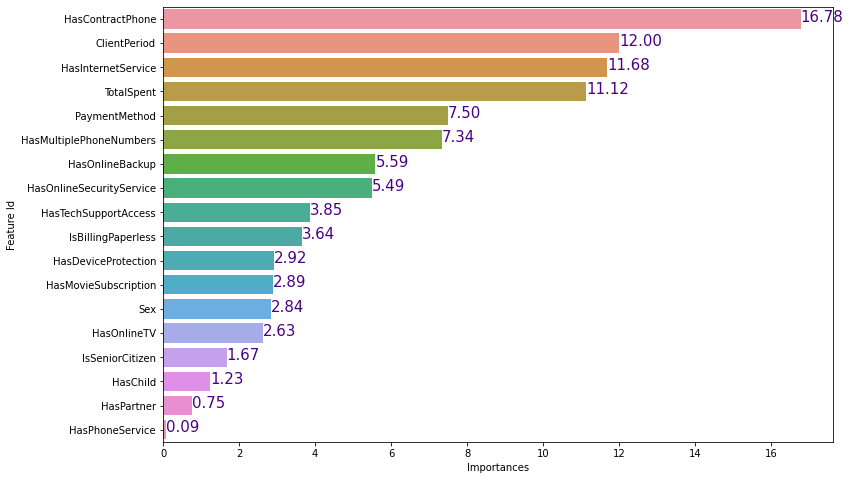

In [ ]:
df_fimp = model.get_feature_importance(prettified=True)
plt.figure(figsize=(12,8))
ax = sns.barplot(x=df_fimp.columns[1], y=df_fimp.columns[0], data=df_fimp);

for p in ax.patches:
    x = p.get_width()
    y = p.get_y()
    text = '{:.2f}'.format(p.get_width())
    ax.text(x, y,text,fontsize=15,color='indigo',va='top',ha='left')


Ну а это уже второй график, без удаленных фич

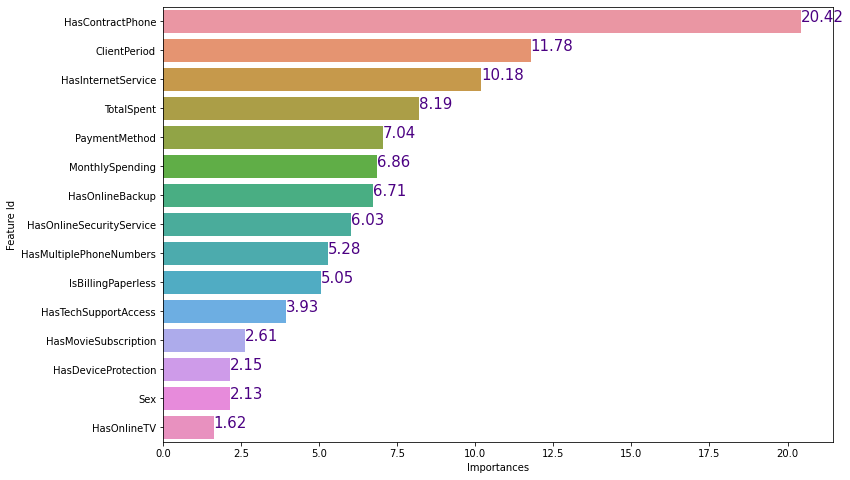

In [ ]:
df_fimp = model.get_feature_importance(prettified=True)
plt.figure(figsize=(12,8))
ax = sns.barplot(x=df_fimp.columns[1], y=df_fimp.columns[0], data=df_fimp);

for p in ax.patches:
    x = p.get_width()
    y = p.get_y()
    text = '{:.2f}'.format(p.get_width())
    ax.text(x, y,text,fontsize=15,color='indigo',va='top',ha='left')


##  Результаты
Основные показатели для задачи классификации

In [ ]:
# main metrics
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       763
           1       0.68      0.54      0.60       294

    accuracy                           0.80      1057
   macro avg       0.76      0.72      0.73      1057
weighted avg       0.79      0.80      0.79      1057



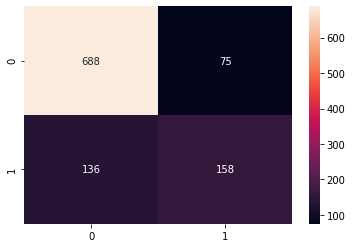

In [ ]:
# confusion matrix - could be better
y_pred = model.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')

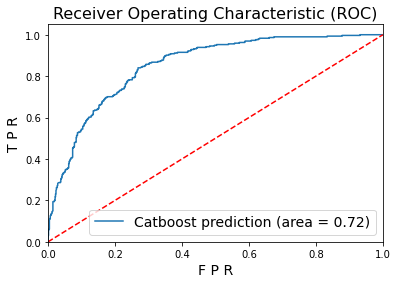

In [ ]:
# roc-auc - bearable, okish model, could be better, though
logit_roc_auc = roc_auc_score(y_val, model.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Catboost prediction (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('F P R', fontsize=14)
plt.ylabel('T P R', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('ROC', fontsize=14)
plt.show();

Интерпретация модели/важность признаков

In [ ]:
import shap
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(train_pool) 

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

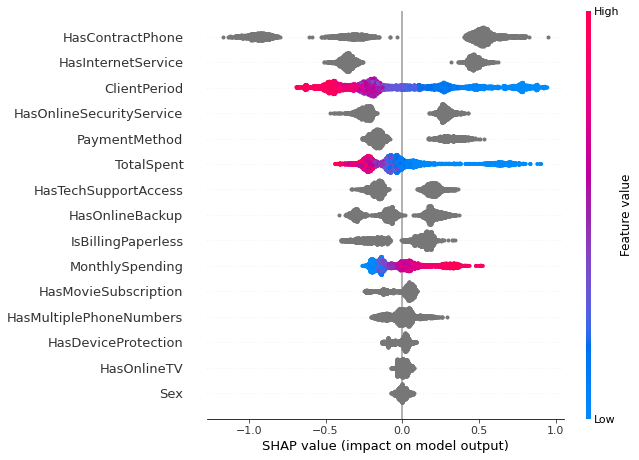

In [ ]:
shap.summary_plot(shap_values, X_train)

## Лирическое отступление
Что было сделано и мне лично НЕ помогло, возможно стоило делать как-то по-другому:
*  Заменить  TotalSpent на 0 - что было логично: ухудшало качество
* Выкинуть признаки с высокой корреляцией, например, MonthlySpending: ухудшало качество
* Подбор параметров по сетке для Catboost: результат тот же
* Попытки решить проблему дисбаланса классов - андерсэмплинг/оверсэмплинг: и при генерации объеков, и при использовании подвыборки качество падало
* Попытки объединить предсказания нескольких моделей: качество либо падало, либо оставалось прежним

# Предсказания

Тут кратко-лаконично, ибо говорить уже нечего (скор на паблик 0.8526, Alexandra_Izhevskaya)


In [ ]:
best_model = model
preds_proba = best_model.predict_proba(test)[:,1]
submission = pd.read_csv('/content/submission.csv')
submission['Churn'] = preds_proba
submission.to_csv('./my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.